In [3]:
# import modules
import numpy as np
import tensorflow as tf
import pickle
import gzip
import random
import time
import os
from keras.preprocessing.sequence import pad_sequences
from IPython.display import Image, display
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu
from tqdm import tqdm_notebook as tqdm

In [4]:
# return image feature dict, caption dict
def load_data(dtype):
    if dtype == 'train':
        filename = './Flickr8k_text/Flickr_8k.trainImages.txt'
    elif dtype == 'valid':
        filename = './Flickr8k_text/Flickr_8k.devImages.txt'
    elif dtype == 'test':
        filename = './Flickr8k_text/Flickr_8k.testImages.txt'
        
    image_ids = []
    features = dict()
    captions = dict()
    
    # get image ids
    with open(filename, 'r') as f:
        lines = f.read().split('\n')
        image_ids = [x.split('.')[0] for x in lines if x] # remove '.jpg'
        
    # get image features
    with gzip.open('./image_features.pkl.zip', 'rb') as f:
        all_featuers = pickle.load(f)
        features = { x: all_featuers[x][0] for x in image_ids }
        
    # get image cpations
    with open('./captions.txt', 'r') as f:
        lines = f.read().split('\n')
        for l in lines:
            tokens = l.split(' ')
            image_id = tokens[0]
            caption = ' '.join(tokens[1:])
            
            # 해당 dataset에 있는 image에 대해서 caption을 가져옴
            if image_id not in image_ids:
                continue
            
            if image_id in captions:
                captions[image_id].append(caption)
            else:
                captions[image_id] = [caption]
            
            
    return features, captions

In [5]:
train_features, train_captions = load_data('train')
# valid_features, valid_captions = load_data('valid')
test_features, test_captions = load_data('test')

print('# of images in train:', len(train_features), len(train_captions))
# print('# of images in valid:', len(valid_features))
print('# of images in test:', len(test_features), len(test_captions))

print('feature shape:', list(train_features.items())[0][1].shape)

# of images in train: 6000 6000
# of images in test: 1000 1000
feature shape: (4096,)


In [6]:
# check if wrong key(image_id) in feature dict and caption dict
key_tr_feat = set([x for x in train_features])
key_tr_capt = set([x for x in train_captions])
print(key_tr_capt - key_tr_feat)
print(key_tr_feat - key_tr_capt)

set()
set()


In [7]:
# caption에 있는 word 중 5번 이상 등장한 word만 사용하여
# word_to_idx, idx_to_word dict를 만듬
# word를 vector화 하여 input으로 주기 위함
# return word_to_idx, idx_to_word, vocab_size

def preprocess_vocab(captions):
    threshold = 20 # threshold of occurence
    count = dict()
    word_to_idx, idx_to_word = dict(), list()

    for caption_list in captions.values():
        for c in caption_list:
            tokens = c.split(' ')
            for t in tokens:
                if t in count:
                    count[t] += 1
                else:
                    count[t] = 1
            
    print('# total of words:', len(count))
    print('# of words that appears >= {}:'.format(threshold), len([w for w in count if count[w] >= threshold]))

    idx_to_word = [w for w in count if count[w] >= threshold]
    idx_to_word.append('<START>')
    idx_to_word.append('<END>')
    for i, w in enumerate(idx_to_word):
        word_to_idx[w] = i
        
    return word_to_idx, idx_to_word, len(idx_to_word)
    
    

In [8]:
# vocab_size: 우리가 사용할 총 단어의 수
# 각 caption을 index vector로 encoding할 수 있음
word_to_idx, idx_to_word, vocab_size = preprocess_vocab(train_captions)
print('vocab_size:', vocab_size)

# total of words: 7576
# of words that appears >= 20: 1065
vocab_size: 1067


In [9]:
# train set을 만듬
# ex) feature: cap1, cap2, cap3, cap4, cap5
# -> [feature, ... feature], [cap1, ... cap5]
def dict_to_list(features, captions):
    image_ids, feat, capt = [], [], []
    for image_id in features:
        _feat = features[image_id]
        _capt = captions[image_id]
        for c in _capt:
            image_ids.append(image_id)
            feat.append(_feat)
            c = '<START> ' + c + ' <END>'
            capt.append(c)
            
    return image_ids, np.array(feat), np.array(capt)

In [10]:
def display_image(image_id):
    image_filename = './Flicker8k_Dataset/' + image_id + '.jpg'
    display(Image(filename=image_filename))

len(image_ids): 30000
len(feat): 30000
len(capt): 30000


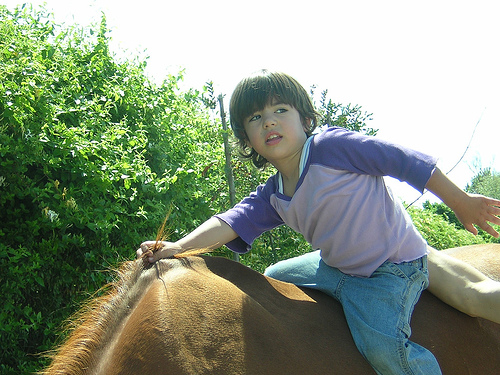

505955292_026f1489f2 [0. 0. 0. ... 0. 0. 0.] <START> boy rides horse <END>


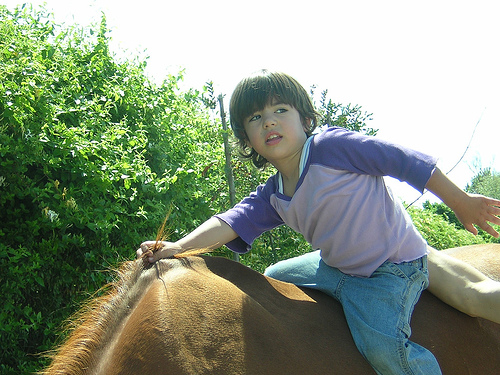

505955292_026f1489f2 [0. 0. 0. ... 0. 0. 0.] <START> young boy rides brown horse bareback <END>


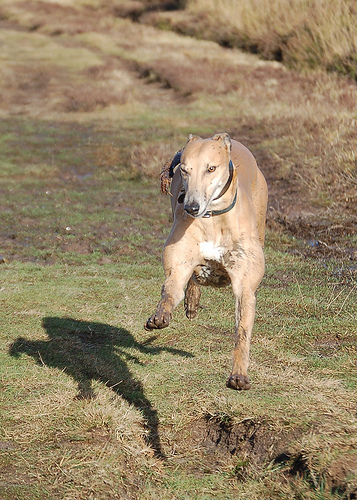

2493469969_11b6190615 [1.9292125 0.        1.9889582 ... 1.0514048 0.        0.       ] <START> medium sized brown dog jumping <END>


In [11]:
image_ids, feats, capts = dict_to_list(train_features, train_captions)
print('len(image_ids):', len(image_ids))
print('len(feat):', len(feats))
print('len(capt):', len(capts))
display_image(image_ids[0])
print(image_ids[0], feats[0], capts[0])
display_image(image_ids[1])
print(image_ids[1], feats[1], capts[1])
display_image(image_ids[6])
print(image_ids[6], feats[6], capts[6])

In [12]:
# calculate maxlen
maxlen = 0
for c in capts:
     maxlen = max(maxlen, len(c.split(' ')))

print('maxlen in train captions:', maxlen)

maxlen in train captions: 34


In [13]:
# caption generator model
class Model():
    def __init__(self, dim_img, dim_embed, dim_hidden, batch_size, maxlen, vocab_size):

        self.dim_img = dim_img
        self.dim_embed = dim_embed
        self.dim_hidden = dim_hidden
        self.batch_size = batch_size
        self.maxlen = maxlen # max seq length include (<START>, <END>)
        self.vocab_size = vocab_size
#         print('model hyper params')
#         print('dim_img:', dim_img)
#         print('dim_embed:', dim_embed)
#         print('dim_hidden:', dim_hidden)
#         print('batch_size:', batch_size)
#         print('maxlen:', maxlen)
#         print('vocab_size:', vocab_size)
        
        # lstm cell
        with tf.variable_scope('lstm'):
            self.lstm = tf.contrib.rnn.LSTMCell(dim_hidden)

        # word embedding
        with tf.variable_scope('word_embedding'):
            self.word_embedding_w = tf.get_variable(name='word_embedding_w',
                                                    shape=[self.vocab_size, self.dim_embed])
            self.word_embedding_b = tf.get_variable(name='word_embedding_b',
                                                    shape=[self.dim_embed])

        # image embedding
        with tf.variable_scope('image_embedding'):
            self.img_embedding_w = tf.get_variable(name='img_embedding_w',
                                                  shape=[self.dim_img, self.dim_embed])
            self.img_embedding_b = tf.get_variable(name='img_embedding_b',
                                                  shape=[self.dim_embed])
            
        # word encoding(lstm output -> word index)
        with tf.variable_scope('word_encoding'):
            self.word_encoding_w = tf.get_variable(name='word_encoding_w',
                                                  shape=[self.dim_hidden, self.vocab_size])
            self.word_encoding_b = tf.get_variable(name='word_encoding_b',
                                                  shape=[self.vocab_size])


    # return placeholders for training and runnable components
    def build_model(self):
        img_feat = tf.placeholder(tf.float32, [self.batch_size, self.dim_img], name='img_feat_tr')
        caption = tf.placeholder(tf.int32, [self.batch_size, self.maxlen], name='caption_tr') # include <START>, <END>
        mask = tf.placeholder(tf.float32, [self.batch_size, self.maxlen], name='mask_tr') # use mask when calculate XE
        
        # image embedding
        img_embedding = tf.matmul(img_feat, self.img_embedding_w) + self.img_embedding_b
        
        # word embedding
        word_embedding = tf.nn.embedding_lookup(self.word_embedding_w, caption) + self.word_embedding_b
        print('word_embedding.shape:', word_embedding.shape) # (N, maxlen, embed_size)
        
        # img embedding is first input of lstm
        state = self.lstm.zero_state(self.batch_size, dtype=tf.float32)
        _, state = self.lstm(img_embedding, state)
        
        outputs, state = tf.nn.dynamic_rnn(self.lstm, word_embedding[:, :-1, :], initial_state=state)
        print('outputs.shape:', outputs.shape) # (N, maxlen-1, hidden_size)
        
        # outputs: (N, maxlen-1, hidden_size) -> (N*(maxlen-1), hidden_size)
        outputs = tf.reshape(outputs, [self.batch_size*(self.maxlen-1), self.dim_hidden])

        # word encoding: (N*(maxlen-1), hidden_size) -> (N*(maxlen-1), vocab_size)
        logits = tf.matmul(outputs, self.word_encoding_w) + self.word_encoding_b
        
        # logits: (N*(maxlen-1), vocab_size) -> (N, maxlen-1, vocab_size)
        logits = tf.reshape(logits, [self.batch_size, self.maxlen-1, self.vocab_size])
        
        # labels: (N, maxlen-1)
        labels = caption[:, 1:]
        
        # cross entropy
        # xe: (N, maxlen-1)
        xe = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels)
        
        # apply mask
        xe = xe * mask[:, :-1]
        
        # loss
        loss = tf.reduce_sum(xe) / tf.reduce_sum(mask[:, :-1])

        return loss, img_feat, caption, mask
    
    # return placeholders for generating caption and runnable component
    def build_generator(self):
        img_feat = tf.placeholder(tf.float32, [self.dim_img], name='img_feat_ge') # (img_feature)
        img_feat = tf.expand_dims(img_feat, axis=0) # (1, img_feature)

        # image embedding
        img_embedding = tf.matmul(img_feat, self.img_embedding_w) + self.img_embedding_b
        
        # img embedding is first input of lstm        
        state = self.lstm.zero_state(1, dtype=tf.float32)
        _, state = self.lstm(img_embedding, state)
        
        pred = [tf.constant(word_to_idx['<START>'], dtype=tf.int32)] # add <START> token
        for i in range(self.maxlen-1):
            curr = tf.nn.embedding_lookup(self.word_embedding_w, pred[-1]) + self.word_embedding_b
            curr = tf.expand_dims(curr, axis=0) # (1, embed_size)
            out, state = self.lstm(curr, state)
#             print('out.shape:', out.shape) # (1, hidden)
            out = tf.matmul(out, self.word_encoding_w) + self.word_encoding_b
            pred.append(tf.argmax(out, axis=1)[0])
            
        return img_feat, pred

In [14]:
def train(learning_rate):
    
    tf.reset_default_graph()

    model = Model(dim_img, dim_embed, dim_hidden, batch_size, maxlen, vocab_size)
    loss, image, caption, mask = model.build_model()
    
    saver = tf.train.Saver(max_to_keep=1)
    train_op = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())

        index = np.arange(len(feats)) # for shuffling train set
        for epoch in tqdm(range(n_epochs)):
            np.random.shuffle(index) # shuffle train set

            start_time = time.time() # time measure
            loss_sum = 0
            loss_count = 0
            
            for start, end in zip( range(0, len(index), batch_size), range(batch_size, len(index), batch_size)):
                current_feats = feats[index[start:end]] # image feature
                current_captions = capts[index[start:end]] # caption string
                current_caption_ind = [x for x in map(lambda cap: [word_to_idx[word] for word in cap.split(' ') if word in word_to_idx], current_captions)]

                current_caption_matrix = pad_sequences(current_caption_ind, padding='post', maxlen=maxlen) # <START>, <END>를 포함한 length, 오른쪽에 padding 추
                current_mask_matrix = np.zeros((current_caption_matrix.shape[0], current_caption_matrix.shape[1]))
                nonzeros = np.array([len(x) for x in current_caption_ind])

                # fill mask matrix
                for ind, row in enumerate(current_mask_matrix):
                    row[:nonzeros[ind]-1] = 1

                _, loss_value = sess.run([train_op, loss], feed_dict={
                    image: current_feats.astype(np.float32),
                    caption : current_caption_matrix.astype(np.int32),
                    mask : current_mask_matrix.astype(np.float32)
                    })

                print('batch loss: {} \t Epoch {}/{} \t Iter {}/{}'.format(loss_value, epoch, n_epochs, start, len(feats)), end='\r')
                loss_sum += loss_value
                loss_count += 1

            end_time = time.time() # time measure
            avg_loss = loss_sum / loss_count
            print('1 epoch Elapsed: {}sec, avg loss: {}, Saving the model from epoch: {}'.format(
                end_time-start_time, avg_loss, epoch))
            saver.save(sess, os.path.join(model_path, 'model'), global_step=epoch+1)

In [15]:
### Parameters ###
dim_embed = 256
dim_hidden = 512
dim_img = 4096
batch_size = 128
n_epochs = 50
learning_rate = 0.001
model_path = './tf_checkpoint'

train(learning_rate)

word_embedding.shape: (128, 34, 256)
outputs.shape: (128, 33, 512)


1 epoch Elapsed: 57.24996852874756sec, avg loss: 4.4865795659203815, Saving the model from epoch: 0
1 epoch Elapsed: 56.677499294281006sec, avg loss: 3.588856384285495, Saving the model from epoch: 1
1 epoch Elapsed: 56.21967148780823sec, avg loss: 3.272183611861661, Saving the model from epoch: 2
1 epoch Elapsed: 56.33237886428833sec, avg loss: 3.097512788242764, Saving the model from epoch: 3
1 epoch Elapsed: 56.26871299743652sec, avg loss: 2.971807242458702, Saving the model from epoch: 4
1 epoch Elapsed: 56.73159098625183sec, avg loss: 2.8729340316902876, Saving the model from epoch: 5
1 epoch Elapsed: 56.285149812698364sec, avg loss: 2.7858722953714876, Saving the model from epoch: 6
1 epoch Elapsed: 56.57612919807434sec, avg loss: 2.7087525516493707, Saving the model from epoch: 7
1 epoch Elapsed: 56.34955382347107sec, avg loss: 2.6354008444354067, Saving the model from epoch: 8
1 epoch Elapsed: 56.50980067253113sec, avg loss: 2.5636461606392493, Saving the model from epoch: 9
1 

In [16]:
# features, captions: type 'dict'
def test(features, captions):
    
    tf.reset_default_graph()
    
    maxlen = 30 # 예측할 max 길이
    model = Model(dim_img, dim_embed, dim_hidden, batch_size, maxlen, vocab_size)
    img, pred = model.build_generator()
    saver = tf.train.Saver()
    
    max_example = [0, 0, 0] # (blue_score, image_id, pred)
    min_example = [1, 0, 0] # (blue_score, image_id, pred)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        saved_path = tf.train.latest_checkpoint(model_path)
        print('saved_path:', saved_path)
        saver.restore(sess, saved_path)
        
        refs, hyps = [], [] # for corpus_bleu score
        
        for idx, image_id in enumerate(features):
            print('{}/{}'.format(idx+1, len(features)), end='\r')
            image_feature = features[image_id] # (4096,)
            image_feature = np.expand_dims(image_feature, axis=0) # (1, 4096)
            ref = captions[image_id]
            ref = [x.split() for x in ref] # exclude <START>, <END>
            p = sess.run(pred, feed_dict={ img: image_feature }) # include <START>, <END>
            
            # index to word
            hyp = []
            for i in p:
                curr = idx_to_word[i]
                if curr == '<START>':
                    continue
                    
                elif curr == '<END>':
                    break
                    
                hyp.append(curr)

            # sentence bleu score
            bleu_score = sentence_bleu(ref, hyp, weights=(1.0, 0, 0, 0))
            
            # corpus bleu score
            refs.append(ref)
            hyps.append(hyp)
            
            if bleu_score > max_example[0]:
                max_example[0] = bleu_score
                max_example[1] = image_id
                max_example[2] = hyp

            if bleu_score < min_example[0]:
                min_example[0] = bleu_score
                min_example[1] = image_id
                min_example[2] = hyp

    display_image(max_example[1])
    print('image_id:', max_example[1])
    print('answer')
    for row in captions[max_example[1]]:
        print(row)

    print('pred')
    print(max_example[2])
    print('bleu:', max_example[0])
    
    
    display_image(min_example[1])
    print('image_id:', min_example[1])
    print('answer')
    for row in captions[min_example[1]]:
        print(row)

    print('pred')
    print(min_example[2])
    print('bleu:', min_example[0])

    print('corpus_bleu-1:', corpus_bleu(refs, hyps, weights=(1,0,0,0)))
    

saved_path: ./tf_checkpoint/model-50
INFO:tensorflow:Restoring parameters from ./tf_checkpoint/model-50


/home/bmy4415/.conda/envs/myenv/lib/python3.5/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/bmy4415/.conda/envs/myenv/lib/python3.5/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/bmy4415/.conda/envs/myenv/lib/python3.5/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using low

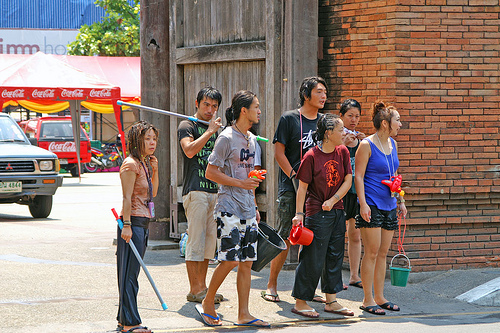

image_id: 3447007090_08d997833a
answer
group of people cross the street with buckets and poles
group of seven asian girls and boys are waiting to cross street
group of teenagers wait to cross the street
group of young adults are standing on street in front of brick wall with tall wooden gate
group of young adults with buckets and soaking wet on street
pred
['group', 'of', 'young', 'adults', 'are', 'standing', 'on', 'street', 'in', 'front', 'of', 'brick', 'wall', 'with', 'tall', 'wooden', 'gate']
bleu: 1.0


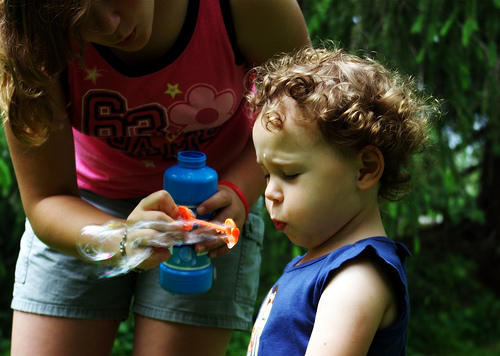

image_id: 2585141045_b496a7b7c4
answer
little boy blows bubbles which are held by young woman
little boy with brown curly hair is blowing bubbles with wand held by girl
small boy blows bubbles through wand held by his mother
woman holding bubble wand for the child to blow bubbles from
woman holds bubble wand while toddler blows bubbles
pred
['two', 'children', 'eating', 'and', 'laughing']
bleu: 0
corpus_bleu-1: 0.7609346201866862


In [17]:
test(train_features, train_captions)

saved_path: ./tf_checkpoint/model-50
INFO:tensorflow:Restoring parameters from ./tf_checkpoint/model-50


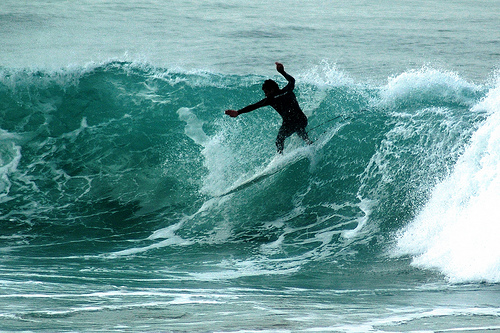

image_id: 3071676551_a65741e372
answer
person rides the waves on surfboard
person surfing
surfer is riding wave
surfer riding large wave
surfer riding surfboard in rough seas
pred
['person', 'surfing', 'wave']
bleu: 1.0


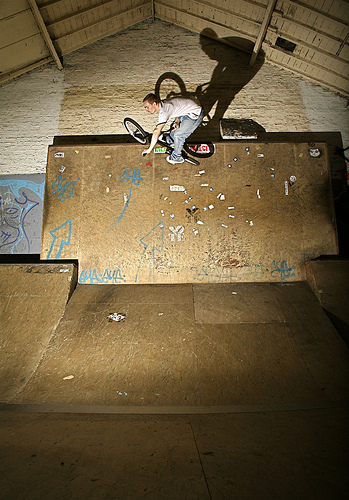

image_id: 2949982320_c704b31626
answer
bmx biker performing wallride on ramp
bmx rider rides the ramp
man is doing tricks with bicycle at skate park
young man does tricks with his bike on course
man on bicycle is doing tricks in an old building
pred
['skateboarder', 'performs', 'trick']
bleu: 0
corpus_bleu-1: 0.43192702394526794


In [18]:
test(test_features, test_captions)

In [19]:
# 주어진 image feature를 이용하여 caption 생성
def sample(image_feature):
    
    tf.reset_default_graph()
    
    maxlen = 20
    image_feature = np.expand_dims(image_feature, axis=0)
    model = Model(dim_img, dim_embed, dim_hidden, batch_size, maxlen, vocab_size)
    img, pred = model.build_generator()
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        saved_path = tf.train.latest_checkpoint(model_path)
        saver.restore(sess, saved_path)

        p = sess.run(pred, feed_dict={ img: image_feature }) # include <START>, <END>

        # index to word
        result = []
        for i in p:
            curr = idx_to_word[i]
            if curr == '<START>':
                continue

            elif curr == '<END>':
                break

            result.append(curr)
            
        return ' '.join(result)

In [20]:
set(key for key in train_captions)

{'1387461595_2fe6925f73',
 '2067362863_59577f9d4d',
 '3726025663_e7d35d23f6',
 '2675190069_d5c3b2c876',
 '2882056260_4399dd4d7c',
 '3717809376_f97611ab84',
 '3174196837_800689a2f3',
 '2186139563_e60c1d4b8b',
 '270263570_3160f360d3',
 '3293596075_973b0bfd08',
 '2403078014_4b1d6f8bde',
 '2068465241_3bcabacfd7',
 '297169473_d3974e0275',
 '3242808166_8638150274',
 '3518118675_5053b3f738',
 '3362189985_fbae8f860a',
 '3089742441_d42531c14f',
 '3221128704_d1205db79b',
 '3677239603_95865a9073',
 '2169951750_495820a215',
 '432496659_f01464d9fb',
 '1402843760_d30f1dbf0f',
 '41999070_838089137e',
 '136639119_6040b00946',
 '3658016590_f761e72dc3',
 '953941506_5082c9160c',
 '2324779494_5e72d29171',
 '160541986_d5be2ab4c1',
 '2969380952_9f1eb7f93b',
 '2930514856_784f17064a',
 '1082252566_8c79beef93',
 '1075867198_27ca2e7efe',
 '527946505_a51ade1578',
 '3221815947_76c95b50b7',
 '3758175529_81941e7cc9',
 '798343627_7492fe0c12',
 '3643074723_94d42b7a0c',
 '3672105509_53b13b2ed4',
 '3286111436_891ae7dab

INFO:tensorflow:Restoring parameters from ./tf_checkpoint/model-50


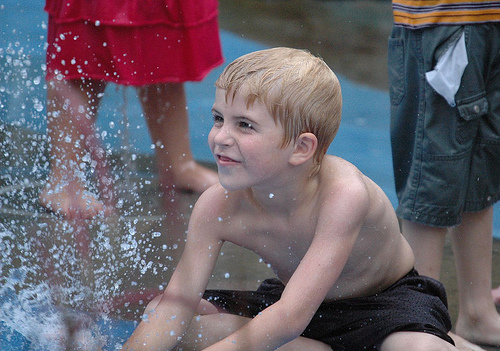

boy in black swimsuit playing near the water
boy is splashing water in his bathing suit
little shirtless boy in shorts splashes water
boy in black swim trunks playing in spray of water
young boy splashes water at the edge of pool
pred
boy in black swimsuit playing in spray of water


In [21]:
# test
image_id = '890734502_a5ae67beac'
image_feature = train_features[image_id]
pred = sample(image_feature)
display_image(image_id)
for c in train_captions[image_id]:
    print(c)
    
print('pred')
print(pred)

INFO:tensorflow:Restoring parameters from ./tf_checkpoint/model-50


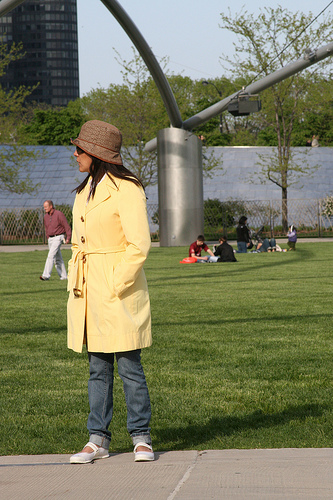

woman in yellow coat is standing on sidewalk
woman in yellow jacket and brown hat stands on path by lake
woman wearing brown hat sunglasses jeans white shoes and yellow trench coat stand on the sidewalk
young woman waits under sculpture in park
woman with hat staring in the distance at park with sculpture
pred
woman wearing brown hat sunglasses and brown jacket stands on sidewalk


In [22]:
# test
image_id = '3524975665_7bec41578b'
image_feature = train_features[image_id]
pred = sample(image_feature)
display_image(image_id)
for c in train_captions[image_id]:
    print(c)
    
print('pred')
print(pred)